In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model import NewsVendorModel
import params

/Users/minegokdere/Desktop/AI4SCM/ai4scm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Simulate game 
agent_types = ['greedy', 'greedy']
model = NewsVendorModel(agent_type=agent_types)

for _ in range(params.ROUNDS):
    model.step()

# Pull data 
model_df = model.datacollector.get_model_vars_dataframe()   # index: Step
agent_df = model.datacollector.get_agent_vars_dataframe()   # index: Step, AgentID

In [7]:
df = agent_df.reset_index()

price_data = df[df["AgentID"] == 1][["Step", "Order Quantity"]].rename(columns={"Order Quantity": "Price"})

qty_data = df[df["AgentID"] == 2][["Step", "Order Quantity", "Reward"]].rename(columns={"Order Quantity": "Quantity"})

combined_df = pd.merge(price_data, qty_data, on="Step")

final_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)

In [8]:
final_df.tail(50)


,Step,Price,Quantity,Reward,Regret,Demand
314,315,18.1,36.0,543.600000,0,33.684290
315,316,18.1,36.0,501.685657,0,79.665458
316,317,6.0,36.0,108.000000,0,29.675762
317,318,18.1,36.0,429.131288,0,46.545839
318,319,18.1,36.0,543.600000,0,24.866964
319,320,18.1,36.0,342.092044,0,44.473503
320,321,18.1,36.0,543.600000,0,34.743489
321,322,18.1,36.0,520.857159,0,48.362471
322,323,18.1,36.0,543.600000,0,44.158690
323,324,18.1,36.0,543.600000,0,54.856462


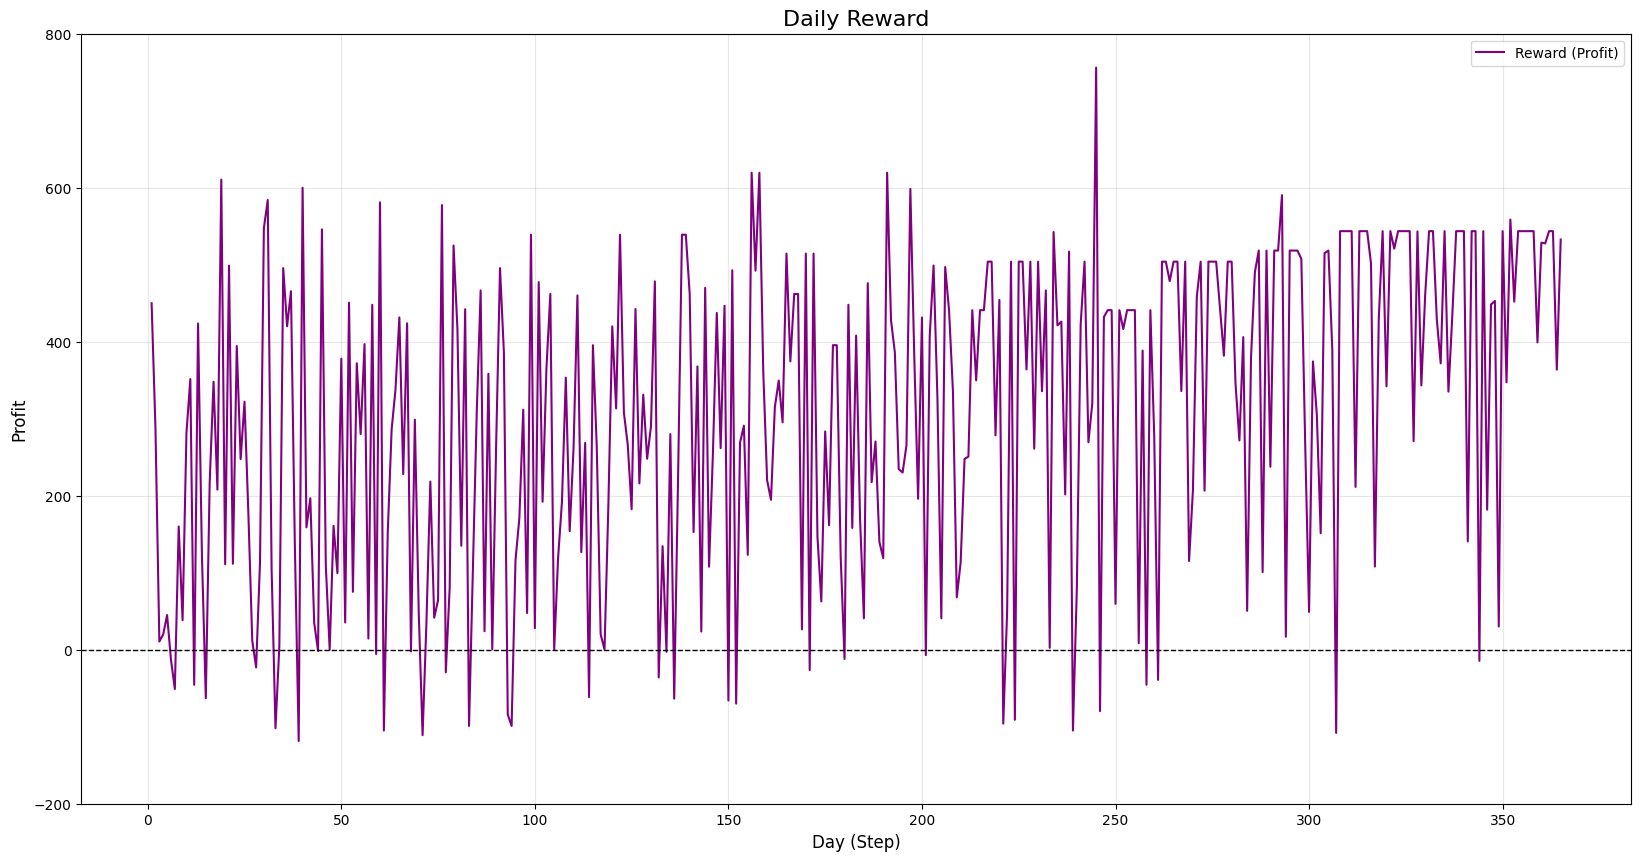

In [9]:
#Reward Plot

reward_data = df[df["AgentID"] == 1][["Step", "Reward"]]

plt.figure(figsize=(20, 10))
plt.plot(reward_data['Step'], reward_data['Reward'], color='purple', label='Reward (Profit)', linewidth=1.5)

plt.ylim(-200, 800)

plt.axhline(0, color='black', linewidth=1, linestyle='--')

plt.xlabel('Day (Step)', fontsize=12)
plt.ylabel('Profit', fontsize=12)
plt.title('Daily Reward', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
print("Optimal (p,q):", params.opt_QP)
print("Optimal expected profit:", params.opt_profit)

Optimal (p,q): (17.6, 40.0)
Optimal expected profit: 497.68295084686594


In [12]:
opt_pair_check=params.all_pairs_profits
max=maxopt_pair_check["expected profit"]

NameError: name 'maxopt_pair_check' is not defined